In [23]:
import os
import platform
from datetime import datetime

import numpy as np
import pandas as pd

if platform.system() == "Windows":
    os.chdir(os.getcwd() + "\\..\\data\\")
elif platform.system() == "Linux":
    os.chdir(os.getcwd() + "/../data/")
print(os.getcwd())

/home/juppo/DataAnalyticsProject/data


In [24]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def parse_measure_data(data : pd.DataFrame):
    # Remove header
    data.drop(range(0, 10), inplace=True)

    # Evaluate date information
    day_info = []
    month_info = []
    year_info = []
    run_info = []
    hour_info = []
    current_day = None
    current_month = None
    current_year = None
    current_run = None
    current_hour = None
    for index, row in data.iterrows():
        day_info.append(current_day)
        month_info.append(current_month)
        year_info.append(current_year)
        run_info.append(current_run)
        hour_info.append(current_hour)
        if row.iloc[1] in months:
            current_day = int(row.iloc[0])
            current_month = row.iloc[1]
            current_year = int(row.iloc[2])
            current_run = int(row.iloc[3].strip().replace("Run ", ""))
            current_hour = f"{row.iloc[4][0:2]}:{row.iloc[4][2:4]}"

    # Change column names
    data.columns = ['post', 'degrees', 'azimuth_degrees', 'wind_direction', '50', '100', '200']

    # Add date info to the dataframe
    data['run'] = run_info
    # Convert to pandas Timestamp
    timestamps = [pd.Timestamp(year=y, month=months.index(m)+1, day=d, hour=int(h.split(':')[0]), minute=int(h.split(':')[1])) if y is not None else None for y, m, d, h in zip(year_info, month_info, day_info, hour_info)]
    data['timestamp'] = timestamps

    # Change data types
    data['post'] = pd.to_numeric(data['post'], errors='coerce')
    data['post'] = data['post'].astype(int, errors='ignore')

    data['degrees'] = pd.to_numeric(data['degrees'], errors='coerce')
    data['degrees'] = data['degrees'].astype(int, errors='ignore')

    data['azimuth_degrees'] = pd.to_numeric(data['azimuth_degrees'], errors='coerce')
    data['azimuth_degrees'] = data['azimuth_degrees'].astype(int, errors='ignore')

    data['wind_direction'] = pd.to_numeric(data['wind_direction'], errors='coerce')
    data['50'] = pd.to_numeric(data['50'], errors='coerce')
    data['100'] = pd.to_numeric(data['100'], errors='coerce')
    data['200'] = pd.to_numeric(data['200'], errors='coerce')

    # Drop NaN values
    to_drop = data[data['post'].isna() | data['degrees'].isna()].index
    data.drop(to_drop, inplace=True)

    # Reset index
    data.reset_index(drop=True, inplace=True)

    return data


In [25]:
def add_additional_data(data: pd.DataFrame, meteo_data: pd.DataFrame, columns = None):
    # Drop rows until relevant data is reached
    i = 0
    for index, row in meteo_data.iterrows():
        if str(row.iloc[1]).strip().lower() == "run":
            i = index
            break
    meteo_data.drop(range(0, i), inplace=True)
    meteo_data.reset_index(drop=True, inplace=True)
    # Check if data type row exists
    data_type_exists = False
    if str(meteo_data.iloc[1, 1]).strip().lower() == 'number':
        data_type_exists = True
    # Drop first column
    meteo_data.drop(columns = [meteo_data.columns[0]], inplace=True)

    # Add meteo data as new columns
    meteo_info = []

    # Use only specified columns
    meteo_data = meteo_data if columns is None else meteo_data.iloc[:, 0:len(columns)]

    for index, row in data.iterrows():
        run = row['run']
        meteo_info.append(meteo_data.iloc[int(run) if not data_type_exists else int(run) + 1])

    # Convert obtained values to a pandas DataFrame
    meteo_columns = pd.DataFrame(data=meteo_info)
    meteo_columns.columns = [c.strip() for c in meteo_data.iloc[0]] if columns is None else columns

    # Drop run column, if present
    run_column_names = ['Run', 'run']
    for run_column_name in run_column_names:
        if run_column_name in meteo_columns.columns:
            meteo_columns.drop(columns=[run_column_name], inplace=True)

    # Concat the two dataframes
    meteo_columns.reset_index(inplace=True, drop=True)
    return pd.concat([data, meteo_columns], axis='columns')



In [26]:
data1 = pd.read_excel(os.getcwd() + "/RHILL1Update01.XLS", sheet_name=2)
data1_meteo = pd.read_excel(os.getcwd() + "/RHILL1Update01.XLS", sheet_name=1)
data1_correction = pd.read_excel(os.getcwd() + "/RHILL1Update01.XLS", sheet_name=0)

data2 = pd.read_excel(os.getcwd() + "/RHILL2Update01.XLS", sheet_name=2)
data2_meteo = pd.read_excel(os.getcwd() + "/RHILL2Update01.XLS", sheet_name=1)
data2_correction = pd.read_excel(os.getcwd() + "/RHILL2Update01.XLS", sheet_name=0)

parsed1 = add_additional_data(parse_measure_data(data1), data1_meteo, ['Wind Speed'])
parsed1 = add_additional_data(parsed1, data1_correction, ['Run', 'Q', 'Correction 50 m', 'Correction 100 m', 'Correction 200 m'])

parsed2 = parse_measure_data(data2.iloc[:, 0:7])
parsed2 = add_additional_data(parsed2, data2_meteo, ['Wind Speed'])
parsed2 = add_additional_data(parsed2, data2_correction, ['Run', 'Source 10 min', 'Source 3 min', 'Source 05 min', 'Correction 10 min', 'Correction 3 min', 'Correction 05 min'])

In [27]:
parsed1

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Q,Correction 50 m,Correction 100 m,Correction 200 m
0,7.0,18.0,43.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
1,8.0,21.0,46.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
2,9.0,24.0,49.0,NaN,NaN,NaN,0.010,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
3,10.0,27.0,52.0,0.42,NaN,NaN,0.015,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
4,11.0,30.0,55.0,NaN,NaN,NaN,0.005,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,27.0,78.0,103.0,4.32,3.330,0.38,0.035,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
899,28.0,81.0,106.0,0.66,0.710,0.07,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
900,29.0,84.0,109.0,0.17,0.015,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
901,30.0,87.0,112.0,0.17,NaN,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97


In [28]:
parsed2

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Source 10 min,Source 3 min,Source 05 min,Correction 10 min,Correction 3 min,Correction 05 min
0,37.0,1.5,76.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
1,38.0,1.5,78.0,0.42,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
2,39.0,1.5,79.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
3,40.0,1.5,81.0,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
4,41.0,1.5,82.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,75.0,1.5,133.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
563,76.0,1.5,135.0,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
564,77.0,1.5,136.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
565,78.0,1.5,138.0,0.42,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97


# Correzioni
Il dataset specifica dei fattori di correzione da applicare ai dati sperimentali. Questi dipendono dalla variazione nel tasso di rilascio della fonte di gas utilizzata.

In [29]:
parsed1_corrected = parsed1.copy(deep=True)

parsed1_corrected['50'] = parsed1['50'] * parsed1['Correction 50 m']
parsed1_corrected['100'] = parsed1['100'] * parsed1['Correction 100 m']
parsed1_corrected['200'] = parsed1['200'] * parsed1['Correction 200 m']

parsed2_corrected = parsed2.copy(deep=True)

parsed2_corrected['50'] = parsed2['50'] * parsed2['Correction 10 min']
parsed2_corrected['100'] = parsed2['100'] * parsed2['Correction 10 min']
parsed2_corrected['200'] = parsed2['200'] * parsed2['Correction 10 min']

In [30]:
parsed1_corrected

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Q,Correction 50 m,Correction 100 m,Correction 200 m
0,7.0,18.0,43.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
1,8.0,21.0,46.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
2,9.0,24.0,49.0,NaN,NaN,NaN,0.00920,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
3,10.0,27.0,52.0,0.42,NaN,NaN,0.01380,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
4,11.0,30.0,55.0,NaN,NaN,NaN,0.00460,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,27.0,78.0,103.0,4.32,3.1968,0.3648,0.03395,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
899,28.0,81.0,106.0,0.66,0.6816,0.0672,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
900,29.0,84.0,109.0,0.17,0.0144,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
901,30.0,87.0,112.0,0.17,NaN,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97


In [31]:
parsed2_corrected

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Source 10 min,Source 3 min,Source 05 min,Correction 10 min,Correction 3 min,Correction 05 min
0,37.0,1.5,76.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
1,38.0,1.5,78.0,0.42,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
2,39.0,1.5,79.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
3,40.0,1.5,81.0,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
4,41.0,1.5,82.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,75.0,1.5,133.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
563,76.0,1.5,135.0,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
564,77.0,1.5,136.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
565,78.0,1.5,138.0,0.42,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97


# Risultati della correzione

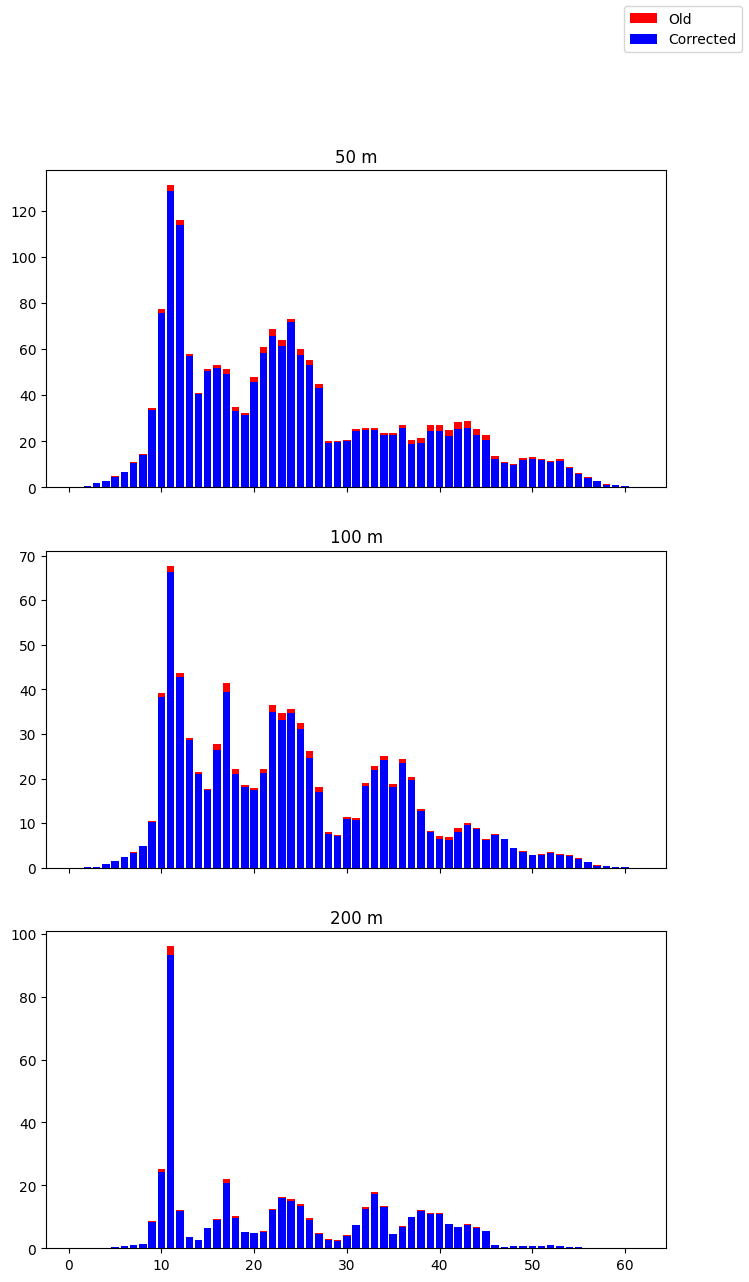

In [32]:
import matplotlib.pyplot as plt

distances = ['50', '100', '200']

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

for i, d in enumerate(distances):
    ax[i].set_title(f"{d} m")
    ax[i].bar(parsed1['post'], parsed1[d], color='r')
    ax[i].bar(parsed1_corrected['post'], parsed1_corrected[d], color='b')
fig.legend(['Old', 'Corrected'])
plt.show()

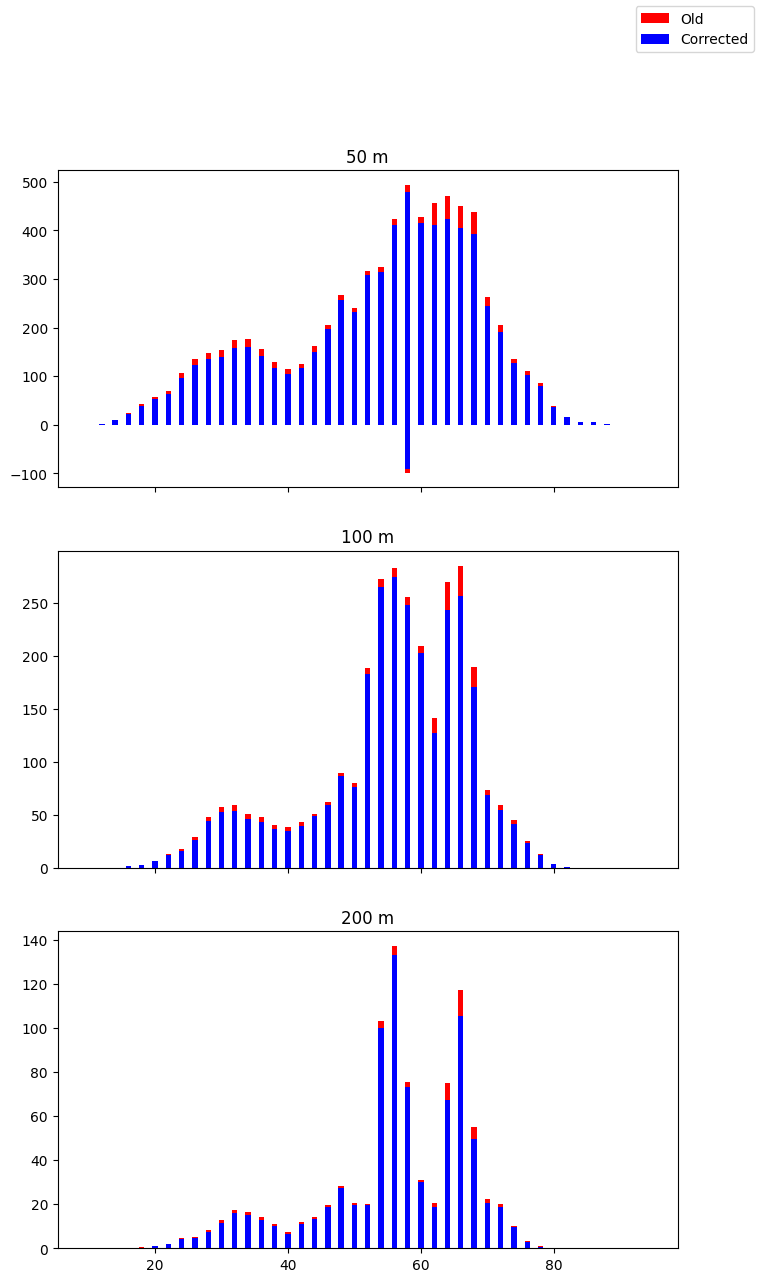

In [33]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

for i, d in enumerate(distances):
    ax[i].set_title(f"{d} m")
    ax[i].bar(parsed2['post'], parsed2[d], color='r')
    ax[i].bar(parsed2_corrected['post'], parsed2_corrected[d], color='b')
fig.legend(['Old', 'Corrected'])
plt.show()

# Data Imputation
Molti valori nelle colonne 50, 100, 200 sono NaN. Questo è corretto, dato che la concentrazione di gas è nulla nei punti il cui il gas non è arrivato. Allo stesso tempo, i sensori (post), sono situati a distanze ravvicinate (1.5 gradi rispetto alla sorgente).
Alcuni di essi non registrano valori di concentrazione, anche se sensori vicini lo fanno. Per risolvere questa inconsistenza nei dati i valore NaN nella riga i viene sostituito con la media tra i valori in i-1 e i+1. Gli altri valori vengono sostituiti con 0

In [34]:
def fill_nan_between(data: pd.DataFrame, columns: list):
    new_data = data.copy(deep=True)
    for column in columns:
        for i, null in enumerate(data[column].isnull()):
            if i == 0 or i == data.shape[0] - 1:
                continue
            if null:
                new_data.loc[i, column] = (new_data.loc[i+1, column] + new_data.loc[i-1, column]) / 2
    return new_data

parsed1_filled = fill_nan_between(parsed1_corrected, distances)
parsed2_filled = fill_nan_between(parsed2_corrected, distances)

In [35]:
parsed1_filled

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Q,Correction 50 m,Correction 100 m,Correction 200 m
0,7.0,18.0,43.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
1,8.0,21.0,46.0,NaN,NaN,NaN,NaN,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
2,9.0,24.0,49.0,NaN,NaN,NaN,0.00920,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
3,10.0,27.0,52.0,0.42,NaN,NaN,0.01380,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
4,11.0,30.0,55.0,NaN,NaN,NaN,0.00460,1.0,1954-08-13 09:15:00,1,1.00,0.93,0.93,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,27.0,78.0,103.0,4.32,3.1968,0.3648,0.03395,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
899,28.0,81.0,106.0,0.66,0.6816,0.0672,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
900,29.0,84.0,109.0,0.17,0.0144,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97
901,30.0,87.0,112.0,0.17,NaN,NaN,NaN,29.0,1955-11-08 23:10:00,29,7.96,0.96,0.96,0.97


In [36]:
parsed2_filled

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed,Source 10 min,Source 3 min,Source 05 min,Correction 10 min,Correction 3 min,Correction 05 min
0,37.0,1.5,76.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
1,38.0,1.5,78.0,0.42,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
2,39.0,1.5,79.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
3,40.0,1.5,81.0,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
4,41.0,1.5,82.5,NaN,NaN,NaN,NaN,1.0,1957-09-24 19:35:00,1,45.1,45.1,45.1,0.90,0.92,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,75.0,1.5,133.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
563,76.0,1.5,135.0,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
564,77.0,1.5,136.5,NaN,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97
565,78.0,1.5,138.0,0.42,NaN,NaN,NaN,10.0,1957-12-03 11:20:00,10,93.4,97.5,97.5,0.94,0.96,0.97


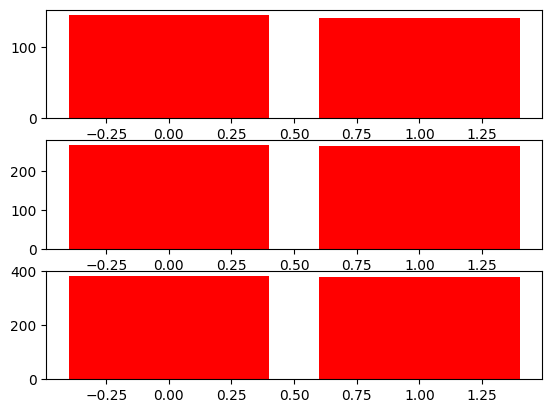

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=1)
for i, d in enumerate(distances):
    null_values = [parsed1_corrected[d].isnull().sum(), parsed1_filled[d].isnull().sum()]
    null_x = [0, 1]
    ax[i].bar(null_x, null_values, color='r', )


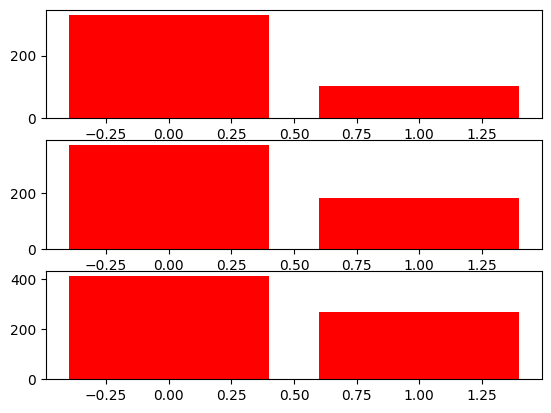

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1)
for i, d in enumerate(distances):
    null_values = [parsed2_corrected[d].isnull().sum(), parsed2_filled[d].isnull().sum()]
    null_x = [0, 1]
    ax[i].bar(null_x, null_values, color='r', )

In [39]:
# Sostituisci i restanti valori NaN con 0
for distance in distances:
    parsed1_filled[distance] = parsed1_filled[distance].fillna(0)
    parsed2_filled[distance] = parsed2_filled[distance].fillna(0)


# Unione dei dataset

In [40]:
data = pd.concat([parsed1_filled.iloc[:, 0:10], parsed2_filled.iloc[:, 0:10]])
data

,post,degrees,azimuth_degrees,wind_direction,50,100,200,run,timestamp,Wind Speed
0,7.0,18.0,43.0,NaN,0.0,0.0,0.0000,1.0,1954-08-13 09:15:00,1
1,8.0,21.0,46.0,NaN,0.0,0.0,0.0000,1.0,1954-08-13 09:15:00,1
2,9.0,24.0,49.0,NaN,0.0,0.0,0.0092,1.0,1954-08-13 09:15:00,1
3,10.0,27.0,52.0,0.42,0.0,0.0,0.0138,1.0,1954-08-13 09:15:00,1
4,11.0,30.0,55.0,NaN,0.0,0.0,0.0046,1.0,1954-08-13 09:15:00,1
...,...,...,...,...,...,...,...,...,...,...
562,75.0,1.5,133.5,NaN,0.0,0.0,0.0000,10.0,1957-12-03 11:20:00,10
563,76.0,1.5,135.0,NaN,0.0,0.0,0.0000,10.0,1957-12-03 11:20:00,10
564,77.0,1.5,136.5,NaN,0.0,0.0,0.0000,10.0,1957-12-03 11:20:00,10
565,78.0,1.5,138.0,0.42,0.0,0.0,0.0000,10.0,1957-12-03 11:20:00,10


# Data Flattening
Le colonne 50, 100, 200, possono essere convertite in righe nel dataset che mostrano la rispettiva concentrazione. Questa trasformazione sarà utile in fase di training del modello.

In [44]:
new_rows = []
for index, row in data.iterrows():
    for distance in distances:
        new_row = row.copy(deep=True)
        new_row['concentration'] = row[distance]
        new_row['distance'] = int(distance)
        new_rows.append(new_row)
flattened_data = pd.DataFrame(new_rows)
flattened_data.reset_index(drop=True, inplace=True)
flattened_data.drop(columns=distances, inplace=True)

In [45]:
flattened_data

,post,degrees,azimuth_degrees,wind_direction,run,timestamp,Wind Speed,concentration,distance
0,7.0,18.0,43.0,NaN,1.0,1954-08-13 09:15:00,1,0.0,50
1,7.0,18.0,43.0,NaN,1.0,1954-08-13 09:15:00,1,0.0,100
2,7.0,18.0,43.0,NaN,1.0,1954-08-13 09:15:00,1,0.0,200
3,8.0,21.0,46.0,NaN,1.0,1954-08-13 09:15:00,1,0.0,50
4,8.0,21.0,46.0,NaN,1.0,1954-08-13 09:15:00,1,0.0,100
...,...,...,...,...,...,...,...,...,...
4405,78.0,1.5,138.0,0.42,10.0,1957-12-03 11:20:00,10,0.0,100
4406,78.0,1.5,138.0,0.42,10.0,1957-12-03 11:20:00,10,0.0,200
4407,79.0,1.5,139.5,NaN,10.0,1957-12-03 11:20:00,10,0.0,50
4408,79.0,1.5,139.5,NaN,10.0,1957-12-03 11:20:00,10,0.0,100


In [43]:
flattened_data.to_csv(os.getcwd() + 'data.csv', index=False)